# Monte Carlo - Standoff Calculation

Author: Tobin Ford | tobin.ford@nrel.gov

2023
***
See Monte Carlo - Arrhenius Degredation for a more in depth guide. Steps will be shortened for brevity.

**Objectives**


In [ ]:
# if running on google colab, uncomment the next line and execute this cell to install the dependencies and prevent "ModuleNotFoundError" in later cells:
# !pip install pvdeg==0.2.0

In [1]:
import pvlib
import numpy as np
import pandas as pd
import pvdeg
import matplotlib.pyplot as plt

In [2]:
# This information helps with debugging and getting support :)
import sys, platform
print("Working on a ", platform.system(), platform.release())
print("Python version ", sys.version)
print("Pandas version ", pd.__version__)
print("Pvlib version ", pvlib.__version__)
print("Pvdeg version ", pvdeg.__version__)

Working on a  Windows 10
Python version  3.10.9 | packaged by Anaconda, Inc. | (main, Mar  8 2023, 10:42:25) [MSC v.1916 64 bit (AMD64)]
Pandas version  2.1.2
Pvlib version  0.10.2
Pvdeg version  0.2.0+43.geb81b39.dirty


### Simple Standoff Calculation

This is copied from another tutorial called `4 - Standards.ipynb`, please visit this page for a more in depth explanation of the process for a single standoff calculation.

<div class="alert alert-block alert-info">
<b>Please use your own API key: The block below makes an NSRDB API to get weather and meta data and then calculate cell temperature and global poa irradiance. This tutorial will work with the DEMO Key provided, but it will take you less than 3 minutes to obtain your own at https://developer.nrel.gov/signup/ so register now.) 
</div>


In [3]:
weather_db = 'PSM3'
weather_id = (40.633365593159226, -73.9945801019899) # Manhattan, NYC
weather_arg = {'api_key': 'DEMO_KEY',
               'email': 'user@mail.com', 
               'names': 'tmy',
               'attributes': [],
               'map_variables': True}

WEATHER, META = pvdeg.weather.get(weather_db, weather_id, **weather_arg)

Column "relative_humidity" not found in DataFrame. Calculating...


In [4]:
sol_pos = pvdeg.spectral.solar_position(WEATHER, META)
poa_irradiance = pvdeg.spectral.poa_irradiance(WEATHER, META)
temp_mod = pvdeg.temperature.module(weather_df=WEATHER, meta=META, poa=poa_irradiance, conf='open_rack_glass_polymer')


In [5]:
# simple standoff calculation
height1 = pvdeg.standards.standoff(
    weather_df = WEATHER,
    meta = META
)

# more arguments standoff calculation
height2 = pvdeg.standards.standoff(weather_df=WEATHER, meta=META,
                                         level=2,
                                         tilt=None,
                                         azimuth=180,
                                         sky_model='isotropic',
                                         temp_model='sapm',
                                         module_type='glass_polymer',
                                         x_0=6.1,
                                         wind_speed_factor=1)

print(height1)
print(height2)

          x      T98_0    T98_inf
0  0.608698  72.506496  46.113842
          x      T98_0    T98_inf
0 -1.524517  72.506496  46.113842


### Defining Correlation Coefficients, Mean and Standard Deviation

We will leave the list of correlations blank because our variables are not correlated. For a correlated use case visit the `Monte Carlo - Arrhenius.ipynb` tutorial.

Mean and standard deviation must always be populated if being used to create a dataset. However, you can feed your own correlated or uncorrelated data into the simulate function but column names must be consistent.

In [6]:
# These numbers do not make sense in the context of the problem but work for demonstraiting the process
stats = {
    'X_0' : {'mean' : 5, 'stdev' : 3},
    'wind_speed_factor' : {'mean' : 0.5, 'stdev' : 0.2} 
}

### TWO CASES (no correlation) ###
# user enters 0 value ✖
# user does leaves blank ✓

# corr_coeff = [pvdeg.montecarlo.Corr('X_0', 'wind_speed_factor', 0)]
corr_coeff = []

samples = pvdeg.montecarlo.generateCorrelatedSamples(corr_coeff, stats, 500)

In [7]:
print(samples)

          X_0  wind_speed_factor
0    1.753928           0.236014
1    0.971727           0.885182
2    7.370995           0.797419
3    8.318067           0.803764
4   -0.528137           0.614987
..        ...                ...
495  2.379927           0.322977
496  6.671859           0.710662
497  9.071650           0.374798
498  6.252152           0.177300
499  2.545639           0.587659

[500 rows x 2 columns]


#### Standoff Monte Carlo Inputs

When using the pvdeg.montecarlo.simulate() function on a target function all of the target function's required arguments must still be given. Our non-changing arguments will be stored in a dictionary. The randomized monte carlo input data will also be passed to the target function via the simulate function. All required target function arguments should be contained between the column names of the randomized input data and fixed argument dictionary, 

In [8]:
# defining arguments to pass to the target function, standoff() in this case
function_kwargs = {
    'weather_df' : WEATHER,
    'meta' : META,
    'level' : 2,
    'tilt' : None,
    'azimuth' : 180,
    'sky_model' : 'isotropic',
    'temp_model' : 'sapm',
    'module_type' : 'glass_polymer'
} 
# notice how we left off parts we want to use in the monte carlo simulation because they are already contained in the dataframe

results = pvdeg.montecarlo.simulate(pvdeg.standards.standoff, samples, **function_kwargs)

#### Dealing With Series 
Notice how our results are contained in a pandas series instead of a dataframe. 

This means we have to do an extra step to view our results. Run the block below to confirm that our results are indeed contained in a series. And convert them into a simpler dataframe.

In [9]:
print(type(results))

results_df = pd.concat(results.tolist()).reset_index(drop=True)

<class 'pandas.core.series.Series'>


In [10]:
print(results_df)

            x      T98_0    T98_inf
0   -0.161133  77.310311  49.357375
1   -0.220199  73.211076  46.518271
2   -1.565222  73.645793  46.787097
3   -1.772060  73.624695  46.773504
4    0.091896  74.824079  47.590501
..        ...        ...        ...
495 -0.263123  76.744561  48.897053
496 -1.320680  74.098569  47.138933
497 -1.109481  76.387964  48.623433
498 -0.474229  77.785537  49.683711
499 -0.423648  75.048391  47.702026

[500 rows x 3 columns]


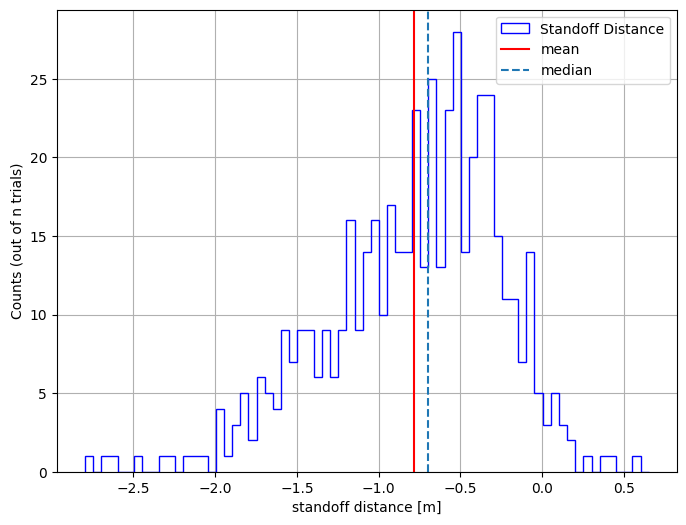

In [12]:
bin_edges = np.arange(results_df['x'].min(), results_df['x'].max() + 0.1, 0.05)
plt.figure(figsize=(8,6))
plt.hist(results_df['x'], bins=bin_edges, edgecolor='blue', histtype='step', linewidth=1, label = 'Standoff Distance')
plt.ylabel('Counts (out of n trials)')
plt.xlabel('standoff distance [m]')
plt.axvline(np.mean(results_df['x']), color = 'red', label = 'mean' )
plt.axvline(np.median(results_df['x']), linestyle='--', label = 'median')

plt.legend()
plt.grid(True)
plt.show()